In [37]:
# numpy < 1.22 required for compatibility wity pytensor theano backend
import numpy as np
import pymc as pm
import csv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import arviz as az
import pytensor.tensor as pt
from itertools import chain
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
local_data = {}
global_data = {}
local_variables = {
    "data/local_data/annual-co2-emissions-per-country.csv":"emissions",
    "data/local_data/forest-area-km.csv":"forest_area",
    "data/local_data/PM25-air-pollution.csv":"air_pollution"
}
global_variables = {
    "data/global_data/global_temp_monthly_avg.tsv":"temperature",
    "data/global_data/global_sea_level.tsv":"sea_level",
    "data/global_data/global-living-planet-index.csv":"biodiversity",
    "data/global_data/co2_annmean_mlo.csv":"emissions"
}
for file in local_variables:
    with open(file) as read_file:
        string_key = local_variables[file]
        local_data[string_key] = {}
        reader = csv.reader(read_file)
        next(reader)
        for line in reader:
            if int(line[2]) >= 1949:
                if line[0] not in local_data[string_key]:
                    local_data[string_key][line[0]] = {}
                local_data[string_key][line[0]][line[2]] = line[3]
with open("data/global_data/global_temp_monthly_avg.tsv") as file:
    reader = csv.reader(file, delimiter=" ")
    next(reader)
    next(reader)
    next(reader)
    global_data["temperature"] = {}
    for line in reader:
        line = [elem for elem in line if elem != ""]
        if int(line[0]) >= 1949:
            # omitting some data here - just taking the last value of each year for now
            global_data["temperature"][line[0]] = line[2]
with open("data/global_data/global_sea_level.tsv") as file:
    reader = csv.reader(file, delimiter="\t")
    next(reader)
    global_data["sea_level"] = {}
    for line in reader:
        year = line[0].split(".")[0]
        month = line[0].split(".")[1]
        # omitting some data here - just taking the last value of each year for now
        if int(year) >= 1949:
            global_data["sea_level"][year] = line[1]
with open("data/global_data/global-living-planet-index.csv") as file:
    reader = csv.reader(file)
    next(reader)
    global_data["biodiversity"] = {}
    for line in reader:
        if int(line[2]) >= 1949:
            if line[0] == "World":
                global_data["biodiversity"][line[2]] = line[3]
with open("data/global_data/co2_annmean_mlo.csv") as file:
    global_data["emissions"] = {}
    reader = csv.reader(file)
    next(reader)
    for line in reader:
        if int(line[0]) >= 1949:
            global_data["emissions"][line[0]] = line[1]

In [50]:
# create local-level data by country
all_countries = set()
all_years = set()
observed_local_data = {}
normalized_observed_local_data = {}
observed_global_data = {var:[] for var in global_variables.values()}
normalized_observed_global_data = {}
scalers = {}
for var in local_variables.values():
    for country, years in local_data[var].items():
        all_countries.add(country)
        for year in years:
            # Note that the years will not be added in order - for now, we are not looking at delayed temporal effects
            all_years.add(year)
for country in all_countries:
    scalers[country] = {}
    observed_local_data[country] = {var:[] for var in local_variables.values()}
    for var in local_variables.values():
        for year in all_years:
            if country in local_data[var] and year in local_data[var][country]:
                observed_local_data[country][var].append(float(local_data[var][country][year]))
            else:
                # missing data
                observed_local_data[country][var].append(np.NaN)
    # normalize out the units
    normalized_observed_local_data[country] = {}
    for var in local_variables.values():
        scalers[country][var] = MinMaxScaler()
        # scalers[country][var] = StandardScaler()
        fit_data = scalers[country][var].fit_transform(np.array(observed_local_data[country][var]).reshape(-1, 1)).flatten()
        normalized_observed_local_data[country][var] = fit_data
for var in global_variables.values():
    for year in all_years:
        if year in global_data[var]:
            observed_global_data[var].append(float(global_data[var][year]))
        else:
            observed_global_data[var].append(np.NaN)
# apply log scale to global emissions
observed_global_data["emissions"] = np.log(observed_global_data["emissions"])
# normalize out the units
for var in global_variables.values():
    scalers[var] = MinMaxScaler()
    # scalers[var] = StandardScaler()
    fit_data = scalers[var].fit_transform(np.array(observed_global_data[var]).reshape(-1, 1)).flatten()
    normalized_observed_global_data[var] = fit_data

In [4]:
dependencies = {
    "forest_area":["wildfire","temperature"],
    "emissions":["air_pollution","temperature"],
    "temperature":["biodiversity","sea_level","wildfire"],
}

In [51]:
country_level_graphs = {}
countries = ["United States","Afghanistan","Spain"]

for country in countries:
# for country in all_countries:
    graph = nx.DiGraph()
    for parent in dependencies:
        for child in dependencies[parent]:
            graph.add_edge(parent,child)
    nx.set_node_attributes(graph, normalized_observed_local_data[country], "observed_data")
    country_level_graphs[country] = graph

global_graph = nx.DiGraph()
for parent in dependencies:
    for child in dependencies[parent]:
        global_graph.add_edge(parent,child)
nx.set_node_attributes(global_graph, normalized_observed_global_data, "observed_data")

normalized_observed_joint_data = {}
for country in countries:
    for key, observation in normalized_observed_local_data[country].items():
        normalized_observed_joint_data[key+f"{country}"] = observation
for key, observation in normalized_observed_global_data.items():
    normalized_observed_joint_data[key] = observation
joint_graph = nx.DiGraph()
for parent in dependencies:
    for child in dependencies[parent]:
        joint_graph.add_edge(parent+"_global",child+"_global")
        for country in countries:
            joint_graph.add_edge(parent+f"_{country}",child+f"_{country}")
            joint_graph.add_edge(parent+f"_{country}", parent+"_global")
            joint_graph.add_edge(child+f"_{country}", child+"_global")
nx.set_node_attributes(joint_graph, normalized_observed_joint_data, "observed_data")

In [44]:
# create country-level models
num_modes = 2
country_models = {}
for country, country_graph in country_level_graphs.items():
    print(country)
    with pm.Model() as model:
        posteriors = {}
        for var in nx.topological_sort(country_graph):
            # remove to include unobserved variables
            if var in nx.get_node_attributes(country_graph, "observed_data"):
                mixture_weights = pm.Dirichlet(f"mixture_weights_{var}", np.array([1]*num_modes))
                sd = pm.HalfNormal(f"sd_{var}", 10, shape=num_modes)
                if len(list(country_graph.predecessors(var))) == 0:
                    prior = pm.Normal(f"prior_{var}", 0, 10, shape=(1, num_modes))
                else:
                    intercepts = pm.Normal(f"intercept_{var}", mu=0, sigma=10, shape=num_modes)
                    term_groups = []
                    for parent in country_graph.predecessors(var):
                        slopes = pm.Normal(f"slope_{parent}_{var}", mu=0, sigma=10, shape=num_modes)
                        prior_list_1 = pt.expand_dims(slopes[0] * posteriors[parent],axis=(1,))
                        prior_list_2 = pt.expand_dims(slopes[1] * posteriors[parent],axis=(1,))
                        prior = pt.concatenate([prior_list_1,prior_list_2],axis=1)
                if var in nx.get_node_attributes(country_graph, "observed_data"):
                    posteriors[var] = pm.NormalMixture(f"posterior_{var}", mixture_weights, prior, sd, observed=nx.get_node_attributes(country_graph, "observed_data")[var])
                else:
                    posteriors[var] = pm.NormalMixture(f"posterior_{var}", mixture_weights, prior, sd)
        prior = pm.sample_prior_predictive()
        trace = pm.sample()
        country_models[country] = {
            "prior":prior,
            "trace":trace,
            "posterior":pm.sample_posterior_predictive(trace, extend_inferencedata=True)
        }

United States


Sampling: [intercept_air_pollution, mixture_weights_air_pollution, mixture_weights_emissions, mixture_weights_forest_area, posterior_air_pollution_observed, posterior_air_pollution_unobserved, posterior_emissions, posterior_forest_area_observed, posterior_forest_area_unobserved, prior_emissions, prior_forest_area, sd_air_pollution, sd_emissions, sd_forest_area, slope_emissions_air_pollution]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mixture_weights_forest_area, sd_forest_area, prior_forest_area, posterior_forest_area_unobserved, mixture_weights_emissions, sd_emissions, prior_emissions, mixture_weights_air_pollution, sd_air_pollution, intercept_air_pollution, slope_emissions_air_pollution, posterior_air_pollution_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [posterior_air_pollution_observed, posterior_air_pollution_unobserved, posterior_emissions, posterior_forest_area_observed]


Afghanistan


Sampling: [intercept_air_pollution, mixture_weights_air_pollution, mixture_weights_emissions, mixture_weights_forest_area, posterior_air_pollution_observed, posterior_air_pollution_unobserved, posterior_emissions, posterior_forest_area_observed, posterior_forest_area_unobserved, prior_emissions, prior_forest_area, sd_air_pollution, sd_emissions, sd_forest_area, slope_emissions_air_pollution]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mixture_weights_forest_area, sd_forest_area, prior_forest_area, posterior_forest_area_unobserved, mixture_weights_emissions, sd_emissions, prior_emissions, mixture_weights_air_pollution, sd_air_pollution, intercept_air_pollution, slope_emissions_air_pollution, posterior_air_pollution_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 527 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [posterior_air_pollution_observed, posterior_air_pollution_unobserved, posterior_emissions, posterior_f

Spain


Sampling: [intercept_air_pollution, mixture_weights_air_pollution, mixture_weights_emissions, mixture_weights_forest_area, posterior_air_pollution_observed, posterior_air_pollution_unobserved, posterior_emissions, posterior_forest_area_observed, posterior_forest_area_unobserved, prior_emissions, prior_forest_area, sd_air_pollution, sd_emissions, sd_forest_area, slope_emissions_air_pollution]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mixture_weights_forest_area, sd_forest_area, prior_forest_area, posterior_forest_area_unobserved, mixture_weights_emissions, sd_emissions, prior_emissions, mixture_weights_air_pollution, sd_air_pollution, intercept_air_pollution, slope_emissions_air_pollution, posterior_air_pollution_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 514 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [posterior_air_pollution_observed, posterior_air_pollution_unobserved, posterior_emissions, posterior_f

In [45]:
# use country-level posteriors to create global model
with pm.Model() as model:
    # compute local priors
    country_coefficients = {}
    local_slopes = {}
    for var in local_variables.values():
        slopes = []
        for country in country_level_graphs:
            country_coef = pm.Normal(f"coef_{country}_{var}", 0, 100)
            slopes.append(country_coef * np.mean(country_models[country]["posterior"]["posterior_predictive"][f"posterior_{var}"][0].data,axis=0))
        local_slopes[var] = np.sum(slopes)
    # compute global distributions
    posteriors = {}
    for var in nx.topological_sort(global_graph):
        prior_sd = pm.HalfNormal(f"prior_sd_{var}", 10)
        if len(list(global_graph.predecessors(var))) == 0:
            if var not in local_slopes:
                prior = pm.Normal(f"prior_{var}", 0, prior_sd)
            else:
                intercept = pm.Normal(f"intercept_{var}", mu=0, sigma=100)
                prior = pm.Normal(f"prior_{var}", local_slopes[var]+intercept, prior_sd)
        else:
            intercept = pm.Normal(f"intercept_{var}", mu=0, sigma=100)
            coefs = []
            for parent in list(global_graph.predecessors(var)):
                coefs.append(pm.Normal(f"slope_{parent}_{var}", mu=0, sigma=10))
            if var in local_slopes:
                coefs.append(local_slopes[var])
            prior = pm.Normal(f"prior_{var}", (np.sum(coefs) + intercept), prior_sd)
        posterior_sd = pm.HalfNormal(f"posterior_sd_{var}", 10)
        if var in nx.get_node_attributes(global_graph, "observed_data"):
            posteriors[var] = pm.Normal(f"posterior_{var}", prior, posterior_sd, observed=nx.get_node_attributes(global_graph, "observed_data")[var])
        else:
            posteriors[var] = pm.Normal(f"posterior_{var}", prior, posterior_sd)
    global_prior = pm.sample_prior_predictive()
    global_trace = pm.sample()
    global_posterior = pm.sample_posterior_predictive(global_trace, extend_inferencedata=True)

Sampling: [coef_Afghanistan_air_pollution, coef_Afghanistan_emissions, coef_Afghanistan_forest_area, coef_Spain_air_pollution, coef_Spain_emissions, coef_Spain_forest_area, coef_United States_air_pollution, coef_United States_emissions, coef_United States_forest_area, intercept_air_pollution, intercept_biodiversity, intercept_emissions, intercept_forest_area, intercept_sea_level, intercept_temperature, intercept_wildfire, posterior_air_pollution, posterior_biodiversity_observed, posterior_biodiversity_unobserved, posterior_emissions_observed, posterior_emissions_unobserved, posterior_forest_area, posterior_sd_air_pollution, posterior_sd_biodiversity, posterior_sd_emissions, posterior_sd_forest_area, posterior_sd_sea_level, posterior_sd_temperature, posterior_sd_wildfire, posterior_sea_level_observed, posterior_sea_level_unobserved, posterior_temperature, posterior_wildfire, prior_air_pollution, prior_biodiversity, prior_emissions, prior_forest_area, prior_sd_air_pollution, prior_sd_bio

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 743 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 859 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [posterior_biodiversity_observed, posterior_emissions_observed, posterior_sea_level_observed, posterior_temperature]


In [241]:
# local/global joint model for emissions
with pm.Model() as model:
    
    num_modes = 2
    
    afg_mw = pm.Dirichlet("afg_mixture_weights", np.array([1]*num_modes))
    esp_mw = pm.Dirichlet("esp_mixture_weights", np.array([1]*num_modes))
    usa_mw = pm.Dirichlet("usa_mixture_weights", np.array([1]*num_modes))
    
    afg_emissions_prior = pm.Normal("afg_prior", .5, 1, shape=(1, num_modes))
    esp_emissions_prior = pm.Normal("esp_prior", .5, 1, shape=(1, num_modes))
    usa_emissions_prior = pm.Normal("usa_prior", .5, 1, shape=(1, num_modes))
    
    afg_emissions_sd = pm.HalfNormal("afg_sd", 1, shape=num_modes)
    esp_emissions_sd = pm.HalfNormal("esp_sd", 1, shape=num_modes)
    usa_emissions_sd = pm.HalfNormal("usa_sd", 1, shape=num_modes)
    
    afg_post = pm.NormalMixture("afg_post", afg_mw, afg_emissions_prior, afg_emissions_sd, observed=nx.get_node_attributes(country_level_graphs["Afghanistan"], "observed_data")["emissions"])
    esp_post = pm.NormalMixture("esp_post", esp_mw, esp_emissions_prior, esp_emissions_sd, observed=nx.get_node_attributes(country_level_graphs["Spain"], "observed_data")["emissions"])
    usa_post = pm.NormalMixture("usa_post", usa_mw, usa_emissions_prior, usa_emissions_sd, observed=nx.get_node_attributes(country_level_graphs["United States"], "observed_data")["emissions"])

    coef_sd = pm.HalfNormal("coef_sd", 1)
    intercept_sd = pm.HalfNormal("intercept_sd", 1)
    
    global_intercept = pm.Normal("intercept", 0, intercept_sd)
    afg_coef = pm.Normal("afg_coef", 0, coef_sd)
    esp_coef = pm.Normal("esp_coef", 0, coef_sd)
    usa_coef = pm.Normal("usa_coef", 0, coef_sd)

    afg_multiplier = pm.Deterministic("afg_multiplier",
        # pt.concatenate([pt.expand_dims(afg_coef[0] * afg_post, axis=(1,)), pt.expand_dims(afg_coef[1] * afg_post, axis=(1,))],axis=1)
        (afg_coef * afg_post)                    
    )
    esp_multiplier = pm.Deterministic("esp_multiplier",
        (esp_coef * esp_post)
    )
    usa_multiplier = pm.Deterministic("usa_multiplier",
        (usa_coef * usa_post)
    )
    global_multiplier = pm.Deterministic("emissions_multiplier",
         afg_multiplier + esp_multiplier + usa_multiplier + global_intercept
    )
    global_prior = pm.TruncatedNormal("global_prior", global_multiplier, .01, lower=0)
    global_post = pm.Exponential("global_post", global_prior, observed=nx.get_node_attributes(global_graph, "observed_data")["emissions"])
    
    emissions_prior = pm.sample_prior_predictive()
    emissions_trace = pm.sample()
    emissions_posterior = pm.sample_posterior_predictive(emissions_trace, extend_inferencedata=True)

Sampling: [afg_coef, afg_mixture_weights, afg_post, afg_prior, afg_sd, coef_sd, esp_coef, esp_mixture_weights, esp_post, esp_prior, esp_sd, global_post_observed, global_post_unobserved, global_prior, intercept, intercept_sd, usa_coef, usa_mixture_weights, usa_post, usa_prior, usa_sd]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [afg_mixture_weights, esp_mixture_weights, usa_mixture_weights, afg_prior, esp_prior, usa_prior, afg_sd, esp_sd, usa_sd, coef_sd, intercept_sd, intercept, afg_coef, esp_coef, usa_coef, global_prior, global_post_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 532 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [afg_post, esp_post,

In [238]:
print(np.mean(np.mean(emissions_posterior["posterior_predictive"]["global_post"][0].data,axis=1)))
print(np.std(np.std(emissions_posterior["posterior_predictive"]["global_post"][0].data,axis=1)))

1.3288087556826504
144.4118734032713


In [94]:
def query_conditional_probability(high_val, low_val, independent_var, dependent_var):
    avg_high_val = []
    avg_low_val = []
    for sample_index in range(len(independent_var)):
        top_percentile = np.percentile(independent_var[sample_index], high_val)
        bottom_percentile = np.percentile(independent_var[sample_index], low_val)
        high_vals = []
        low_vals = []
        for index, val in enumerate(independent_var[sample_index]):
            if val > top_percentile:
                high_vals.append(dependent_var[sample_index][index])
            elif val < bottom_percentile:
                low_vals.append(dependent_var[sample_index][index])
        avg_high_val.append(np.mean(high_vals))
        avg_low_val.append(np.mean(low_vals))
    return np.mean(avg_high_val), np.mean(avg_low_val)

# Ask conditional probability queries against local/global models

In [105]:
# Q1: how does reducing emissions to X level in United States reduce air pollution in United States?
us_emissions = scalers["United States"]["emissions"].inverse_transform(np.array(country_models["United States"]["posterior"]["posterior_predictive"]["posterior_emissions"].data[0]))
us_air_pollution = scalers["United States"]["air_pollution"].inverse_transform(np.array(country_models["United States"]["posterior"]["posterior_predictive"]["posterior_air_pollution"].data[0]))
high_threshold, low_threshold = 66, 33
high_res, low_res = query_conditional_probability(high_threshold, low_threshold, us_emissions, us_air_pollution)
print(f"Air pollution when emissions above {str(high_threshold)} percentile:",high_res)
print(f"Air pollution when emissions below {str(low_threshold)} percentile:",low_res)

Air pollution when emissions above 66 percentile: 9.001033023232527
Air pollution when emissions below 33 percentile: 8.643864351000264


In [106]:
# Q2: how does globally reducing deforestation to X level effect global temperature?
# This is using unobserved global variables inferred from observed local variables - seems to be less reliable
global_deforestation = np.array(global_posterior["posterior"]["posterior_forest_area"].data[0])
global_temperature = np.array(global_posterior["posterior_predictive"]["posterior_temperature"].data[0])
high_threshold, low_threshold = 99, 1
high_res, low_res = query_conditional_probability(high_threshold, low_threshold, global_deforestation, global_temperature)
print(f"Temperature when deforestation is above {str(high_threshold)} percentile:",high_res)
print(f"Temperature when deforestation is below {str(low_threshold)} percentile:",low_res)

Temperature when deforestation is above 99 percentile: 0.011430296041459505
Temperature when deforestation is below 1 percentile: 0.01179704934964179


In [ ]:
# Q3: how does reducing emissions to X level in United States reduce global emissions?
# cannot answer without joint local/global model

In [ ]:
# Q4: how does reducing deforestation to X level in United States effect global temperature?
# cannot answer without joint local/global model

In [100]:
# Q5: which countries are the biggest contributors to global emissions?

# print(np.mean(global_posterior["posterior"]["coef_United States_emissions"].data[0]))
# print(np.std(global_posterior["posterior"]["coef_United States_emissions"].data[0]))
# print(np.mean(global_posterior["posterior"]["coef_Spain_emissions"].data[0]))
# print(np.std(global_posterior["posterior"]["coef_Spain_emissions"].data[0]))

print(np.mean(emissions_posterior["posterior"]["afg_coef"][0].data,axis=0))
print(np.std(emissions_posterior["posterior"]["afg_coef"][0].data,axis=0))
print(np.mean(emissions_posterior["posterior"]["esp_coef"][0].data,axis=0))
print(np.std(emissions_posterior["posterior"]["esp_coef"][0].data,axis=0))
print(np.mean(emissions_posterior["posterior"]["usa_coef"][0].data,axis=0))
print(np.std(emissions_posterior["posterior"]["usa_coef"][0].data,axis=0))

[0.53222454 3.03938843]
[4.09321797e-02 1.00772587e+02]
[ 0.95247227 -3.17555272]
[ 0.1858496  99.97669913]
[-0.24528614 -0.8262012 ]
[ 0.20583096 98.60655379]


In [24]:
# Evaluation

# Sensitivity analysis?
# Withheld data?

# Q1: How well does the model capture the data at the local level?
# compare trace plots to observed data, summary statistics of sampled vs. observed data

# Q2: How well does the model capture the relationships in the data at the local level?
# build the function based on avg slopes/intercepts, then pick a few values to plug into the function and compare to the observed data
for country, model in country_models.items():
    posterior = model["posterior"]["posterior"]
    posterior_predictive = model["posterior_predictive"]
    print(country)
    print(np.mean(posterior["slope_emissions_air_pollution"][0].data))
    print(np.mean(posterior["intercept_air_pollution"][0].data))
    print(posterior_predictive["posterior_emissions"][0].data)
    
# Q3: How well do the local models approximate the data at the global level? 

# Q4: Are the computed results validated by external data sources not used/withheld from this model?

United States
4.918774648688592e-06
-0.11758239082864637
[[ 3.43248226e+05  9.11225309e+00  1.08070817e+06 ... -1.29248756e+05
   2.85538957e+05 -2.36766636e+05]
 [ 1.21217161e+06 -1.14793735e+00  7.85716551e+05 ... -1.54387025e+05
   6.47035642e+05  1.37555043e+05]
 [-6.39320529e+05 -9.80961325e+00 -4.34360765e+05 ... -1.33751743e+06
  -1.52855747e+04 -2.16881935e+05]
 ...
 [-7.74055009e+05 -4.10313668e+01  1.37366604e+05 ...  5.40664223e+05
   1.02902610e+05 -9.58986671e+03]
 [-2.07765971e+05 -1.51756089e+01 -8.13690673e+05 ... -9.70959699e+05
  -1.22514054e+05  2.15415125e+05]
 [-1.21264071e+05  4.74885064e+00 -4.72191730e+05 ... -3.98201615e+04
   1.84789662e+05  6.24186691e+05]]
Afghanistan
3.180648874684335e-05
-0.22021312040181817
[[-8.35960249e+00 -1.14869402e+01 -2.05421389e+01 ... -4.14496361e+00
  -1.07105416e+04  3.22385001e+01]
 [ 2.25771301e+01 -7.29383017e+00  2.44141838e+01 ... -4.30573175e+00
  -1.99662193e+04 -3.69220861e+01]
 [ 3.55138555e+01  1.33930005e+01  4.02756

# Model Visualization

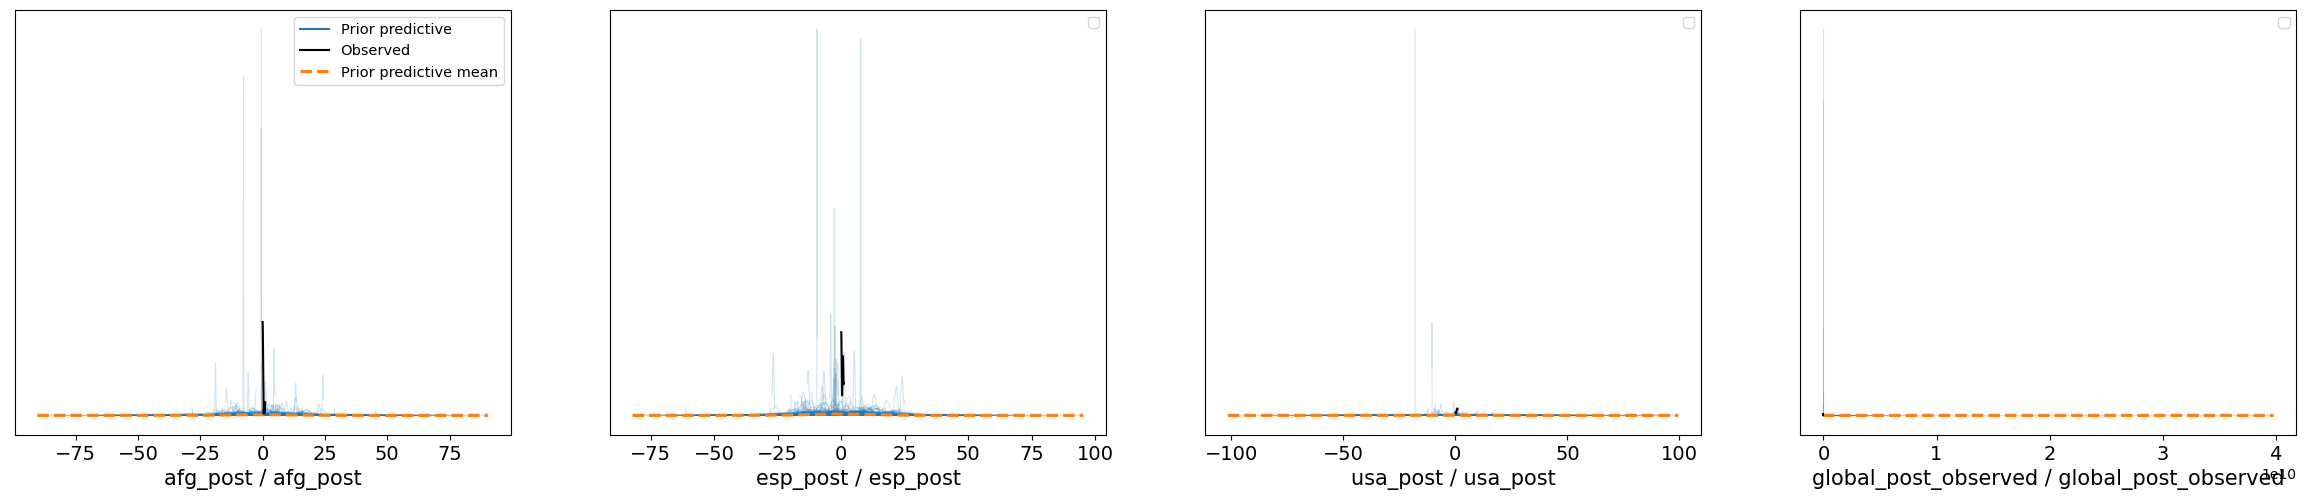

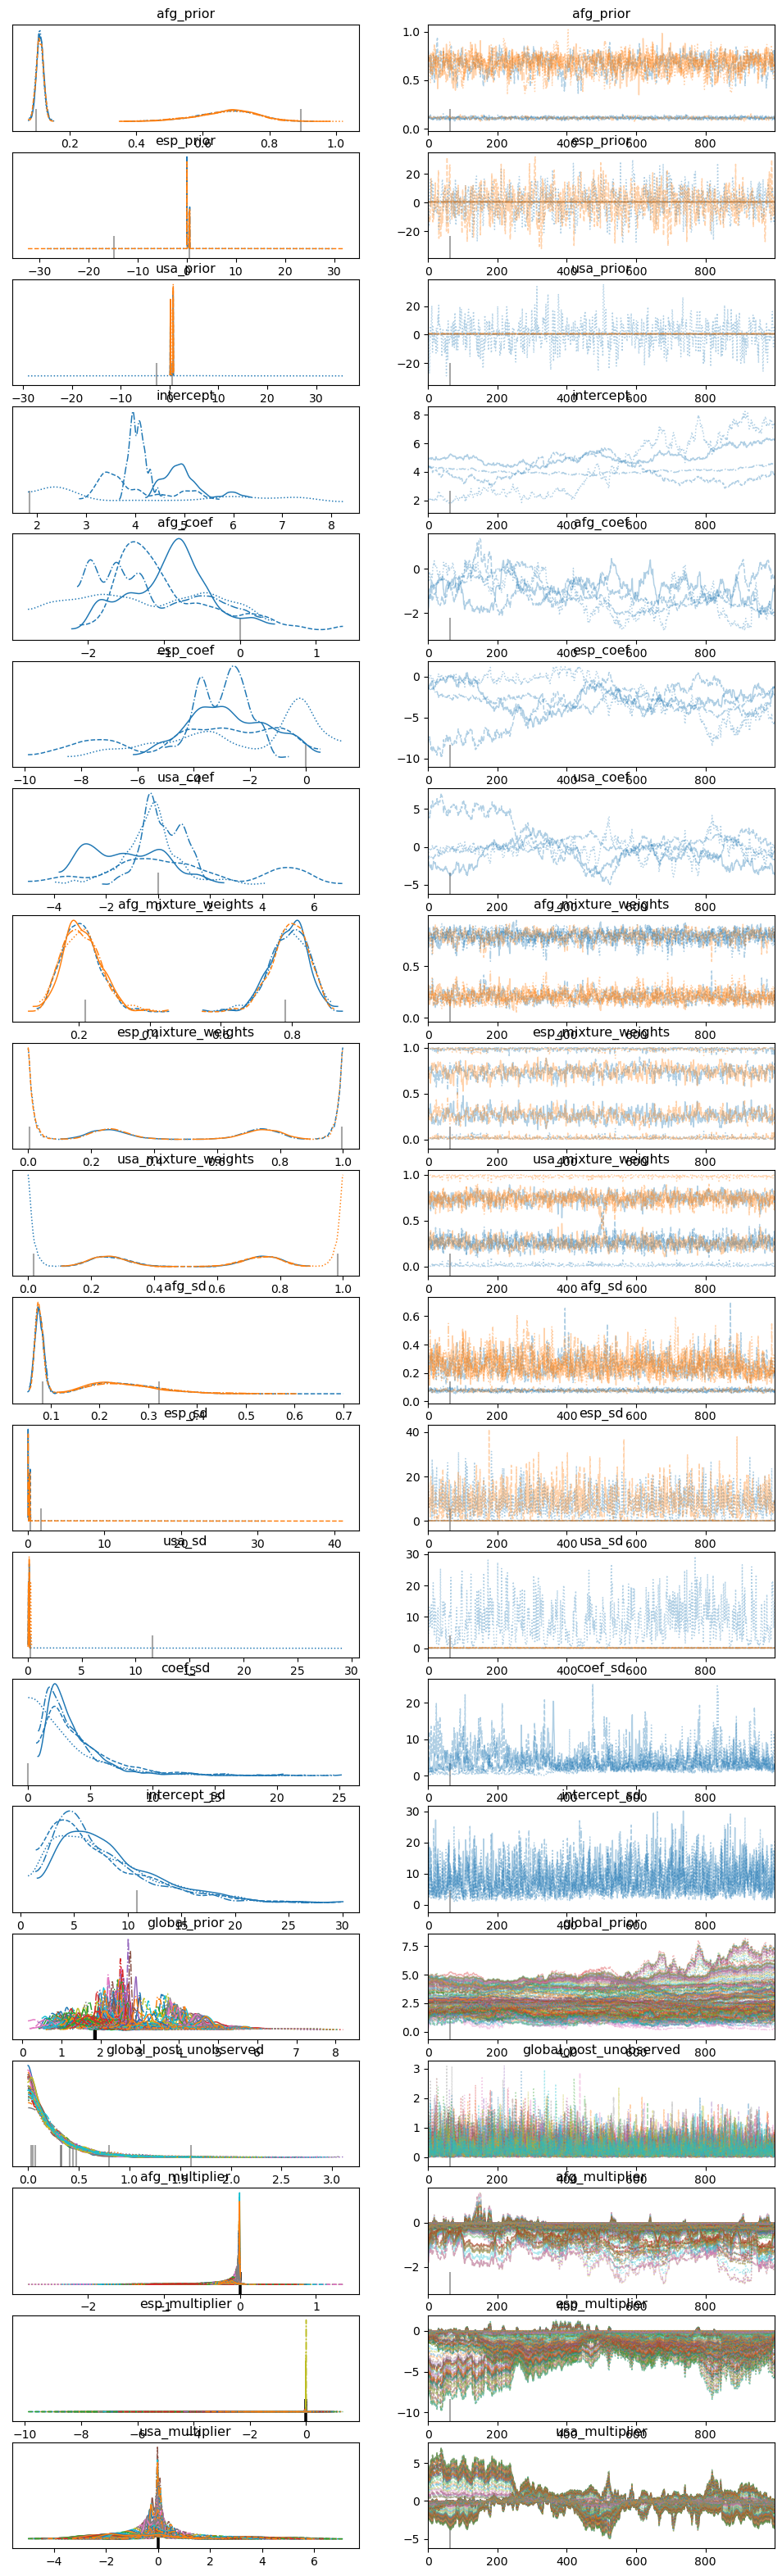

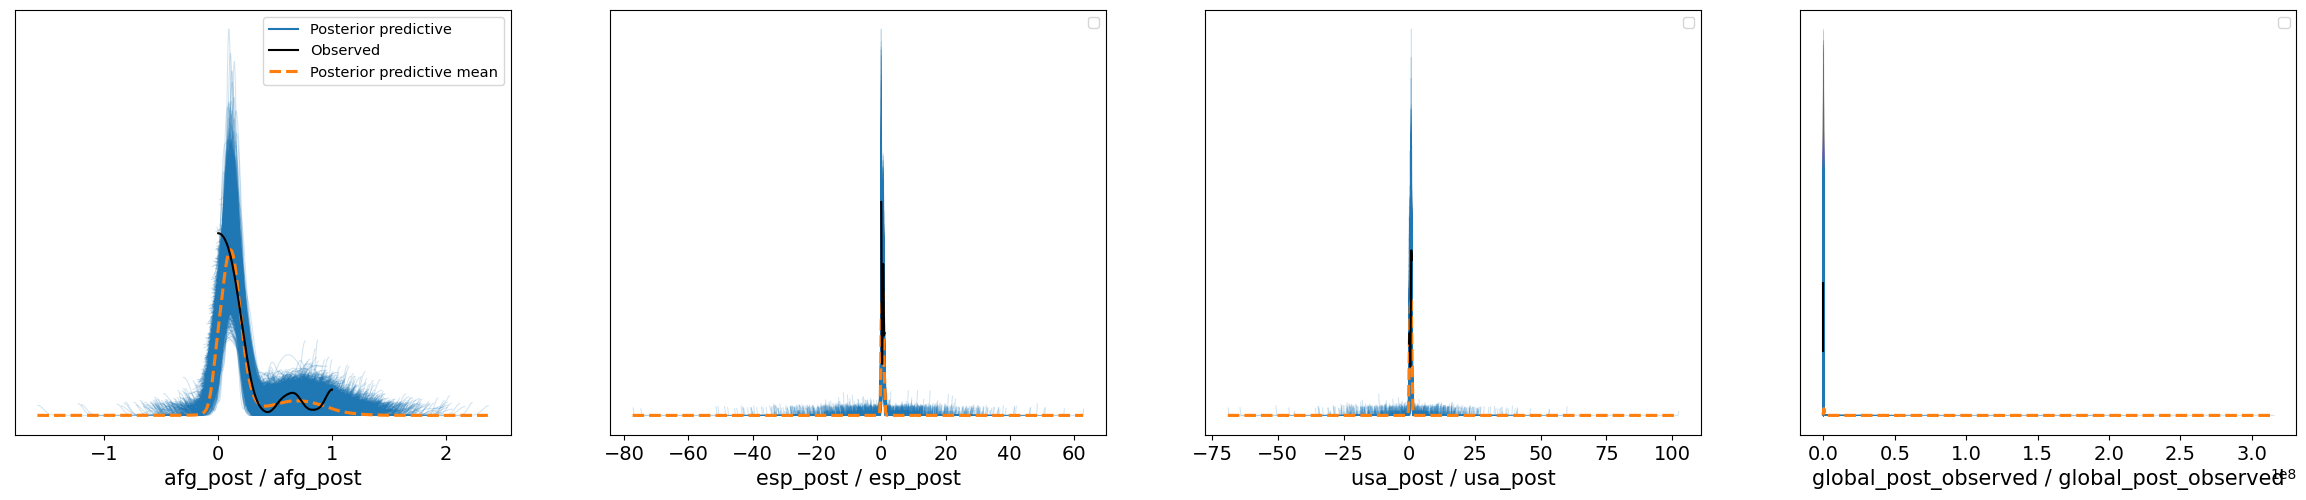

In [242]:
fig = az.plot_ppc(emissions_prior, group="prior").ravel()[0].figure
# fig = az.plot_ppc(emissions_prior, group="prior").figure
fig.show()
fig = az.plot_trace(emissions_trace).ravel()[0].figure
# fig = az.plot_trace(emissions_trace).figure
fig.show()
fig = az.plot_ppc(emissions_posterior).ravel()[0].figure
# fig = az.plot_ppc(emissions_posterior).figure
fig.show()

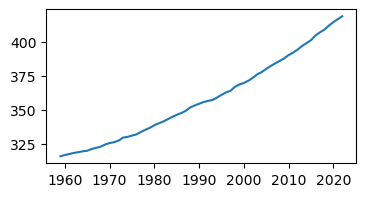

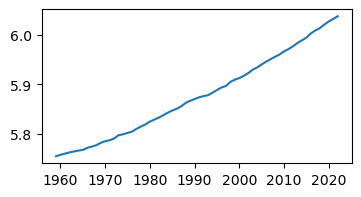

In [19]:
co2_vals = []
years = []
with open("data/global_data/co2_annmean_mlo.csv") as read_file:
    reader = csv.reader(read_file)
    next(reader)
    for line in reader:
        if int(line[0]) >= 1949:
            years.append(int(line[0]))
            co2_vals.append(float(line[1]))

plt.figure(figsize=(4,2))
plt.plot(years, co2_vals)
plt.show()

plt.figure(figsize=(4,2))
plt.plot(years, np.log(co2_vals))
plt.show()